# Module 2 - Image Segmentation and Region Finding

Before the popularization of neural networks, engineers and scientists spent lots of time developing routines to crop out regions of an images. This process of image segmentation and region finding is the first step to classifying images with margin and ensemble classifiers. Once the regions of interest are detected, features can be extracted to train, test, and apply a classifier. 

These techniques are useful for preprocessing data raw data and generating image metrics that preserve the original, physical scale of the data. It also provides a helpful baseline to compare against deep methods.

As with any python application, we first import the necessary libraries.

In [1]:
import numpy as np
import cv2
import skimage
from skimage import filters, morphology, measure
from scipy import ndimage
import sys
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

We have added a new libray to work with: skimage, short for Scikit-Image. This is another image processing toolbox that adds additonal functionality to OpenCV.

To start with, we will pull up a raw SPC image. This is what is directly captured on the sensor *in situ*.

/home/eric/python/pogo_bioobs19_imaging/SHRINK-SPC-UW-1501200429144329-32334591114-000055.png


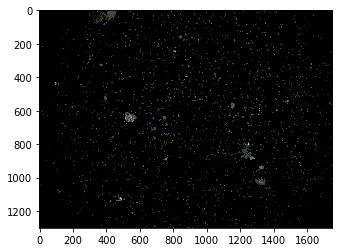

In [2]:
# get the file path of the image in the directory
ptf = glob.glob(os.path.join(os.getcwd(), 'SHRINK-SPC*'))
print(ptf[0])

# We will grab the first item in the list
img = cv2.imread(ptf[0])

# now display it so we can see what we are working with
plt.imshow(img)

This does not look like much. Indeed, most of the full frame image is empty space. But take a closer look. Try taking a subimage from the full frame. Constrain the height between 550 and 700  and the width between 400 and 600.

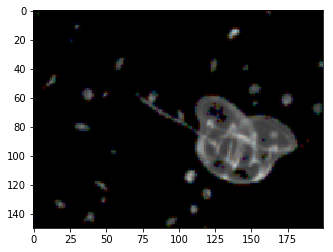

In [3]:
img_sub = img[550:700, 400:600]
plt.imshow(img_sub)

A human can go through and grab everything out of the frame in this manner, but it would be time consuming. Instead, we can use edge detection to find all the objects. 

## Region finding

There are many ways to find regions in an image. The specific method choosen for your data very much depends on the type of images and the background. We will just explore a few here.

It is important to note that none of these are completely fool proof. They all require some amount of human effort to emprically set parameters that dictate the behavior of the algorithm. It is important to test the fidelity of the code under many different conditions to ensure that it is behaving as expected.

### Thresholding

If the image background is uniform enough, setting a binary threshold to find pixels above a certain value might be sufficent. 

In [4]:
# first make a copy of the full image as a gray scale image
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# now look at some of the image parameters. here we will use numpy to compute a few things
print("the max px: ", str(np.max(img_gray)))
print("the min px: ", str(np.min(img_gray)))
print("the mean px: ", str(np.mean(img_gray)))

the max px:  242
the min px:  0
the mean px:  2.619022655426765


Given that most of the image is that minimum value or close to it, the mean might be an effective filter. 

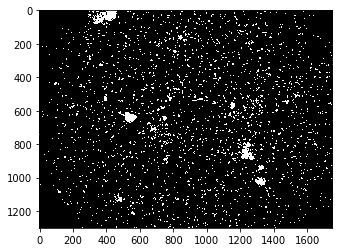

In [5]:
# use numpy to select the pixels and scale it
img_thresh = np.where(img_gray < np.mean(img_gray), 0., 1.0)

plt.imshow(img_thresh, cmap='gray')

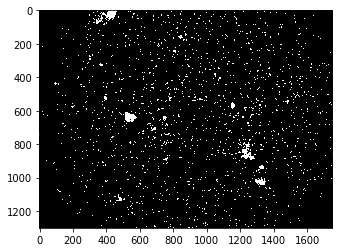

In [6]:
thresh = filters.thresholding.threshold_otsu(img_gray)
test = np.where(img_gray < thresh, 0., 1.0)
plt.imshow(test, cmap='gray')

That mean threhold did not work very well. Given that most of the pixels still made it over the threshold, perhaps a higher value will do the job.

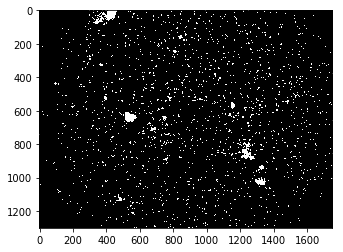

In [7]:
# this time just select a higher number than 5
# use numpy to select the pixels and scale it
img_thresh = np.where(img_gray < 20, 0., 1.0)

plt.imshow(img_thresh, cmap='gray')

That looks quite a bit better. We can zoom in on the diatom and see how it looks.

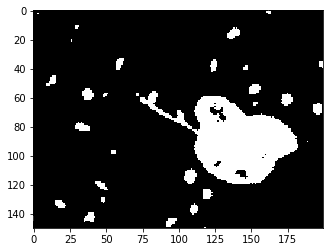

In [8]:
# plot the subregion with the diatom
plt.imshow(img_thresh[550:700, 400:600], cmap='gray')

Generally speaking, thresholding like this will discard a good amount of information. You can see how difficult it would be to select a value that would grab all the stuff you are interested in. 

### Filtering

Another good option for selecting regions in an image is *filtering*. An image filter is a sliding window that is dragged across an image to perform an operation in a neighboorhood around every pixel. A 3x3 median fitler, for example, computes the median value in a 3x3 window around the central pixel. In general, filters have odd numbered dimensions.

Akin to acoustics, filtering images can be described mathematically as a 2D convolution. That means the computer can cast the filtering operation as a multiplication in frequency space, rather than iteratively computing a value at every index. The details go beyond the scope of the tutorial.

There are many different operations that are done with filtering. In fact, convolutional neural networks make use of filters in the feature extraction phase. Here, we will use them to find edges.

#### Edge detection
Edges in images can be modeled as high frequency component of the image matrix. In other words, edges tend to be sharp discontinuities in pixel values. In the image we are working with, the pixels containing the plankton are bright and the background is dark. Where the pixels transition from light to dark will show up as an edge in the image.

We can exploit this to search for edges. First, try out a *Laplacian filter* -- a filter that computes the second derivative within the window. 

uint16


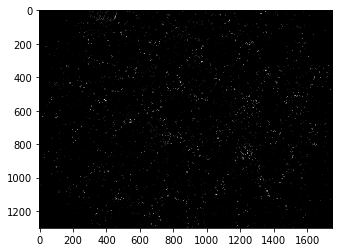

In [9]:
# Use a laplacian filter from OpenCV
img_laplace = cv2.Laplacian(img_gray, cv2.CV_16UC1, ksize=1)

print(img_laplace.dtype)

plt.imshow(img_laplace, cmap='gray')

The second arguement in the Laplacian command specifies the image depth, or data type of the output. We set it to uint16 to increase the percision of the computation. This is not always necessary, but it helps for a mostly empty image. *ksize* specificies the kernel size. ksize=1 gives us a kernal that look likes this:

$$\left[
\begin{matrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0 
\end{matrix}
 \right] $$
 
The 3x3 neighborhood around each pixel is multiplied by this matrix.The resulting values are all added together to get the output for the index at the center. 

This output looks better at a birds eye view. Let's look at that same diatom chain region to see what we get. 

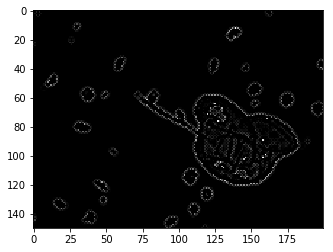

In [10]:
# select subregion and plot
plt.imshow(img_laplace[550:700, 400:600], cmap='gray')

Now we are starting to resolve the outline of the diatom but are seeing lots of noise in there. 

#### Canny edge detector

The Canny edge detector is a multistage algorithm for edge detection written by John Canny in 1986. It works very well in many cases and is a common element of an image processors toolbox. There are 4 steps: 

1. Noise reduction -- generally done with a Gaussian smoothing filter. Basically, make the image a little blurry. 
2. Finding intensity gradients with a filter similar to the Laplacian.
3. Non-maximal suppresion forceses the edges to be thin. This stage outputs a binary images with the range [0 255].
4. Hysteresis thresholding determines which edges are real. This is done based on the minimum and maximum values the engineer gives the algorthm. A value above the max is sure to be an edge. A value below the minimum is sure *not* to be an edge. In between the max and the min, the algorithm checks to see if a line segement connects to a sure edge.

Setting the both the max and minimum values for the hysteresis thresholding high makes the edge detector more conservative. These thresholds need to be tinkered with empirically.

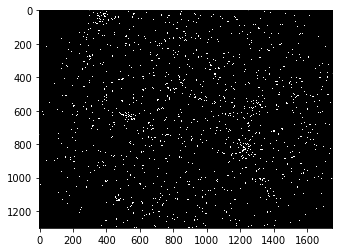

In [11]:
# run canny
img_canny = cv2.Canny(img_gray, 150, 225)

plt.imshow(img_canny, cmap='gray')

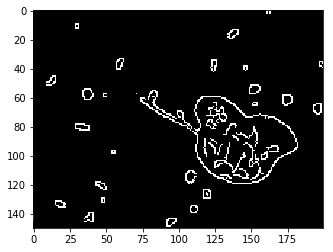

In [12]:
plt.imshow(img_canny[550:700, 400:600], cmap='gray')

Try changing the max and min values of the threshold to see what you get. 

If we want to select and save these regions, we need to create a binary mask to crop out the original pixels.

### Region filling with morphological operators

To make a binary mask, the blank area between the edges needs to be filled in. Doing so requires using 

In [13]:
img_close = morphology.closing(img_canny, morphology.square(7))

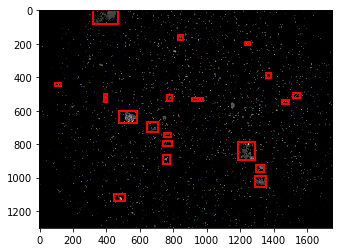

In [14]:
label_img = morphology.label(img_close, neighbors=8, background=0)
props = measure.regionprops(label_img, img_gray, ['Area', 'BoundingBox'])

fig, ax = plt.subplots()
ax.imshow(img, cmap = 'gray')

prop_out = []

# iterate through the regions
for prop in props:
    
    # only select those with an area bigger than 300
    if prop.area > 300:
        
        # save a list of the big ones
        prop_out.append(prop.bbox)
        
        # draw a rectangle the big ones
        minr, minc, maxr, maxc = prop.bbox
        
        rect = ptch.Rectangle((prop.bbox[1], prop.bbox[0]), prop.bbox[3] - prop.bbox[1], prop.bbox[2] - prop.bbox[0],
                          fill=False, edgecolor='red', linewidth=2)

        ax.add_patch(rect)
        
plt.show()